In [2]:
import os
datadir = '/storage/data/special/jp2cache'
# os.listdir(datadir)

In [3]:
pwd

'/storage/code/dali_expt'

In [4]:
import types
import collections
import numpy as np
from random import shuffle

from nvidia.dali.pipeline import Pipeline
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types


In [5]:
import pickle

class TileIterator:
    def __init__(self, jp2path, tilesize=512):
        self.jp2path = jp2path
        infofile = jp2path.replace('.jp2','_info.pkl')
        info = pickle.load(open(infofile,'rb'))
        self.shape = info['shape'] # nr,nc
        self.tileshape = (tilesize,tilesize) # nr,nc
        self.ntiles_c = round(self.shape[1]/tilesize) # FIXME: was ceil, changing to round for compat with ui
        self.ntiles_r = round(self.shape[0]/tilesize) # not actually used anywhere - only print
        self.ntiles = self.ntiles_r * self.ntiles_c
        self.i = -1

    
    def get_rgn(self,tilenum,relative=True):
        tile_r = tilenum//self.ntiles_c
        tile_c = tilenum % self.ntiles_c
        x = self.tileshape[1]*tile_c
        y = self.tileshape[0]*tile_r
        w = min(self.shape[1]-x,self.tileshape[1])
        h = min(self.shape[0]-y,self.tileshape[0])
        if relative:
            return x/self.shape[1], y/self.shape[0], w/self.shape[1],h/self.shape[0]
        else:
            return x,y, w,h
    
    def __iter__(self):
        self.i = -1
        return self
    
    def __next__(self):
        if self.i < self.ntiles:
            self.i+=1
            return self.get_rgn(self.i,False)
        else:
            raise StopIteration()


In [71]:

pipe = Pipeline(batch_size=1, num_threads=16, device_id=0)
with pipe:
    images,_ = fn.readers.file(files=[datadir+'/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2'])
    sl = fn.experimental.decoders.image_slice(images,device='mixed',start=[28160,7680],shape=[512,512])
    pipe.set_outputs(sl, )

pipe.build()
im, = pipe.run()
dat = im.as_cpu()
arr=dat.as_array()
print(arr.shape)

(1, 512, 512, 3)


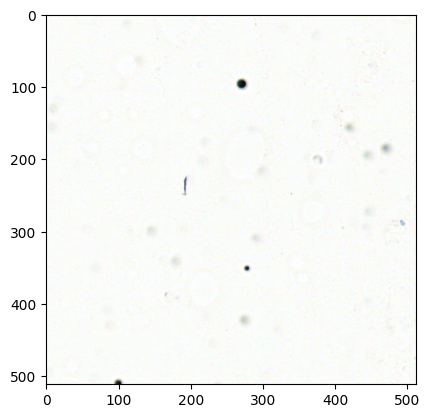

In [72]:
from matplotlib import pyplot as plt
plt.imshow(arr[0,...])

https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/image_processing/decoder_examples.html#Image-Decoder-(CPU)-with-External-Window-Size-and-Anchor

In [8]:
# from functools import partial
import nvidia.dali.types as types
import numpy as np

In [62]:
tileiter = TileIterator(datadir+'/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2',512)

print(tileiter.ntiles)
images,_ = fn.readers.file(files=[tileiter.jp2path])


def ext_source_generator():
    for tilenum in range(2440,2500): #tileiter.ntiles//10):
        x,y,w,h = tileiter.get_rgn(tilenum, False)
        yield np.array([x,y],dtype=np.int32), np.array([w,h],dtype=np.int32)

@pipeline_def(num_threads=16, device_id=0, py_num_workers=4, py_start_method='spawn')
def slice_pipeline(device='mixed'):
    
    rgn_pos, rgn_shp = fn.external_source(source=ext_source_generator, cycle=False, num_outputs=2, batch=False, dtype=types.INT32)
    return fn.experimental.decoders.image_slice(images,device=device,start=rgn_pos,shape=rgn_shp)

25917


In [121]:
pipe2 = slice_pipeline(batch_size=20,device='mixed')

In [122]:
pipe2.build()

In [123]:
%%timeit -n1 -r3

batch_out,=pipe2.run()

11.6 s ± 933 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [119]:
dat = batch_out.as_cpu()
arr=dat.as_array()
print(arr.shape)

(20, 512, 512, 3)


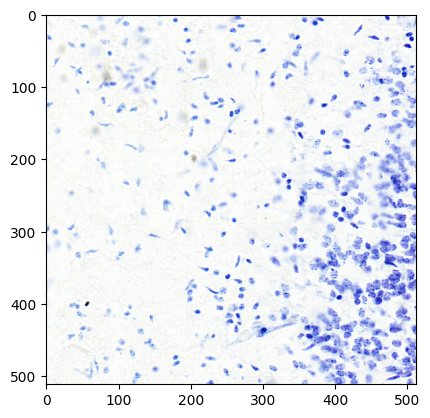

In [120]:
from matplotlib import pyplot as plt
plt.imshow(arr[2,...])

In [91]:
next(iter(ext_source_generator()))

(array([28160,  7680], dtype=int32), array([512, 512], dtype=int32))

In [112]:
pipe2 = slice_pipeline(batch_size=1,device='cpu')

In [113]:
pipe2.build()

In [114]:
# %%timeit -n1 -r3

batch_out=pipe2.run()

RuntimeError: Critical error in pipeline:
Error when executing CPU operator experimental__decoders__ImageSlice encountered:
OpenCV(4.6.0) /tmp/dali_deps/third_party/opencv/modules/imgcodecs/src/loadsave.cpp:77: error: (-215:Assertion failed) pixels <= CV_IO_MAX_IMAGE_PIXELS in function 'validateInputImageSize'

Current pipeline object is no longer valid.

https://docs.opencv.org/4.6.0/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56